<a href="https://colab.research.google.com/github/guylissak/token-classification-transformers-ner/blob/main/Token_Classification_NER%2C_BERT_fine_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Token Classification (NER recognition) - NLP transformer

1. Installations

In [ ]:
!pip install transformers datasets seqeval torchinfo accelerate -U

2. Labels and their IOB mapping to integers

In [42]:
#['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-JOBTITLE', 'I-JOBTITLE', 'B-IND', 'I-IND']
begin2inside = {
  1: 2,
  3: 4,
  5: 6,
  7: 8,
  9: 10
}

label_names = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-JOBTITLE',
               'I-JOBTITLE', 'B-IND', 'I-IND']

id2label = {k: v for k, v in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

print(id2label)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-JOBTITLE', 8: 'I-JOBTITLE', 9: 'B-IND', 10: 'I-IND'}


3. Load and prepare dataset


*   Load dataset from dataset path and split to train/ test
*   Apply tokenization, padding and truncating



In [9]:
from datasets import load_dataset, DatasetDict
from config import config as conf

data = load_dataset("json", data_files=conf.DATASET_PATH)
dataset = data["train"].train_test_split(test_size=0.1, seed=42)
dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 261
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 29
    })
})

In [10]:
from transformers import AutoTokenizer
from config import config as conf
from tokenization_utils import tokenize_fn

# Create tokenizer
tokenizer = AutoTokenizer.from_pretrained(conf.MODEL_CHECKPOINT)

# Apply tokeniztion fn on dataset
tokenized_datasets = dataset.map(lambda batch: tokenize_fn(batch, tokenizer),
                      batched=True,
                      remove_columns=dataset["train"].column_names)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/261 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

4. Model building


*   Download pre tuned model
*   Define training hyper parameters
*   Train and evaluate model



In [13]:
from transformers import AutoModelForTokenClassification, \
 TrainingArguments, \
 Trainer, \
 DataCollatorForTokenClassification
from config import config as conf
from metrics_utils import compute_metrics

# Download pre-trained model (BERT case based in our case)
model = AutoModelForTokenClassification.from_pretrained(
    conf.MODEL_CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
)


# Set training hyper parameters
training_args = TrainingArguments(
    "bert-finetuned-ner-guyl",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=conf.INIT_LR,
    num_train_epochs=conf.NUM_EPOCHS,
    weight_decay=conf.WEIGHT_DECAY
)

# train model
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.312000,0.648628,0.557895,0.670886,0.609195,0.855596
2,0.419700,0.252246,0.764706,0.822785,0.792683,0.931408
3,0.167600,0.135239,0.853659,0.886076,0.869565,0.956679
4,0.071400,0.099567,0.845238,0.898734,0.871166,0.963899
5,0.031900,0.088098,0.879518,0.924051,0.901235,0.971119
6,0.021000,0.090099,0.867470,0.911392,0.888889,0.967509
7,0.014100,0.081953,0.867470,0.911392,0.888889,0.967509
8,0.012900,0.086436,0.867470,0.911392,0.888889,0.967509


TrainOutput(global_step=264, training_loss=0.25633661810195807, metrics={'train_runtime': 780.4409, 'train_samples_per_second': 2.675, 'train_steps_per_second': 0.338, 'total_flos': 14345440494678.0, 'train_loss': 0.25633661810195807, 'epoch': 8.0})

In [41]:
# Display transformer architecture and total paramters count, since the output
# structure has expanded, we will have a little bit more parameters.

from torchinfo import summary
model_input = tokenizer("This is a dummy input", return_tensors="pt")
summary(model, forward_input="Leads from Apple Inc. in United States.")

Layer (type:depth-idx)                                  Param #
BertForTokenClassification                              --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           8,459
Total params: 107,728,139
Trainable params: 107,728,139
Non-trainable params: 0

5. Plot train/ eval losses and accuracy curves

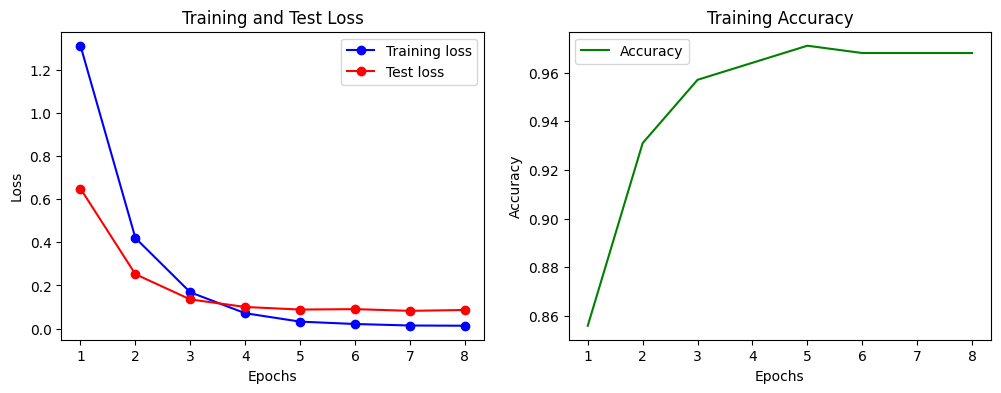

In [24]:
from metrics_utils import get_epochs_metrics
from plot_utils import plot_loss_and_accuracy_curves

# Get training metrics
training_loss, test_loss, accuracy = get_epochs_metrics(trainer)
# Plot accuracy and loss curves
plot_loss_and_accuracy_curves(training_loss, test_loss, accuracy)

6. Save model to path/ load model from path

In [31]:
from model_utils import save_model, load_model

# Save model to folder
save_model(model, conf.MODELS_OUTPUT_PATH)

#Load model from folder, and get a pipeline handler
ner_pipeline = load_model(conf.MODELS_OUTPUT_PATH, id2label, label2id)


Model saved to finetuned_model_weights_ner_bert_guy.pth


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully, NER pipeline is up! :-), enjoy!!!!


7. Custom predictions

In [29]:
q = [
    "Looking for a proffesor from the education industry in Cambridge",
    "Leads from Apple Inc. in United States",
    "James Cohen, CTO, banking industry and sports",
    "Software engineers from United Kingdom industry: education.",
    "Leads from Dior in paris.",
    "IT managers with vice president titles in the valley",
    "VP or CTO in the east cost"
]

for query in q:
  print(f"Input: {query}")
  class_predicctions = ner_pipeline(query)
  print("Output->")
  for i, x in enumerate(class_predicctions):
    print(f"{x['word']}\t{x['entity_group']}")
  print("\n")

Input: Looking for a proffesor from the education industry in Cambridge
Output->
proffesor	JOBTITLE
education industry	IND
Cambridge	LOC


Input: Leads from Apple Inc. in United States
Output->
Apple Inc.	ORG
United States	LOC


Input: James Cohen, CTO, banking industry and sports
Output->
James Cohen	PER
CTO	JOBTITLE
banking industry	IND
sports	IND


Input: Software engineers from United Kingdom industry: education.
Output->
Software engineers	JOBTITLE
United Kingdom	LOC
education	IND


Input: Leads from Dior in paris.
Output->
Dior	ORG
paris	LOC


Input: IT managers with vice president titles in the valley
Output->
IT managers	JOBTITLE
vice president	JOBTITLE
valley	LOC


Input: VP or CTO in the east cost
Output->
VP	JOBTITLE
CTO	JOBTITLE
east	LOC




8. Appendices - Magic commands to export python files in the hierarchy

In [4]:
%%writefile config.py
import os
import torch

class Config:

    DATASET_PATH = "drive/MyDrive/labels.json"
    MODELS_OUTPUT_PATH = "finetuned_model_weights_ner_bert_guy.pth"
    MODEL_CHECKPOINT = "bert-base-cased"
    # Hyper parameters
    INIT_LR = 0.00002
    NUM_EPOCHS = 8
    BATCH_SIZE = 32
    WEIGHT_DECAY = 0.01
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


config = Config()


Writing config.py


In [5]:
%%writefile tokenization_utils.py
""" Tokenization utils """
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer
from typing import List

#['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-JOBTITLE', 'I-JOBTITLE', 'B-IND', 'I-IND']
begin2inside = {
  1: 2,
  3: 4,
  5: 6,
  7: 8,
  9: 10
}

label_names = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-JOBTITLE', 'I-JOBTITLE', 'B-IND', 'I-IND']

def align_targets(labels: List[int], word_ids: List[int]) -> List[int]:
  """
  Aligns token labels with their corresponding word IDs, adjusting labels for subword tokens.
  This function iterates over each token's word ID, generated during tokenization, to align each token
  with its appropriate label. Special tokens (like [CLS], [SEP], etc.) are assigned a label of -100,
  indicating they should be ignored during loss calculation. When a word is split into multiple subword tokens,
  all tokens from the same word are assigned the same label. If necessary, the function adjusts the label
  from 'B-' (beginning) to 'I-' (inside) for subsequent subword tokens of a word, based on a predefined
  mapping (`begin2inside`).
  """
  aligned_labels = []
  last_word = None
  for word in word_ids:
    if word is None:
      # it's a token like [CLS]
      label = -100
    elif word != last_word:
      # it's a new word!
      label = labels[word]
    else:
      # it's the same word as before
      label = labels[word]

      # change B-<tag> to I-<tag> if necessary
      if label in begin2inside:
        label = begin2inside[label]

    # add the label
    aligned_labels.append(label)

    # update last word
    last_word = word

  return aligned_labels

# tokenize both inputs and targets
def tokenize_fn(batch: DatasetDict, tokenizer: AutoTokenizer) -> DatasetDict:
  """
  Tokenizes input sequences and aligns NER labels with the tokenized inputs.

  This function applies a tokenizer to a batch of input sequences, handling both the tokenization
  and the alignment of NER labels with the resulting tokenized inputs. It ensures that each token
  has a corresponding label, appropriately handling special tokens (like [CLS], [SEP]) by assigning
  them a predefined ignore index (-100) and adjusting labels for subword tokens as necessary.

  The function iterates over each sequence in the batch, tokenizes the sequence, and then aligns
  the labels with the tokenized sequence using a custom label alignment function. The aligned labels
  are added to the tokenized inputs under the key 'labels'.
  """

  # tokenize the input sequence first
  # this populates input_ids, attention_mask, etc.
  tokenized_inputs = tokenizer(
    batch['tokens'], truncation=True, is_split_into_words=True
  )

  labels_batch = batch['ner_tags'] # original targets
  aligned_labels_batch = []
  for i, labels in enumerate(labels_batch):
    word_ids = tokenized_inputs.word_ids(i)
    aligned_labels_batch.append(align_targets(labels, word_ids))

  # the 'target' must be stored in key called 'labels'
  tokenized_inputs['labels'] = aligned_labels_batch

  return tokenized_inputs

Writing tokenization_utils.py


In [21]:
%%writefile metrics_utils.py
import numpy as np
from datasets import load_metric
from transformers import Trainer
from typing import Dict, Tuple, List

metric = load_metric("seqeval")

def compute_metrics(logits_and_labels) -> Dict:
  """ Computes precision, recall, f1 score and accuracy """

  logits, labels = logits_and_labels
  preds = np.argmax(logits, axis=-1)
  label_names = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-JOBTITLE', 'I-JOBTITLE', 'B-IND', 'I-IND']

  # remove -100 from labels and predictions
  # and convert the label_ids to label names
  str_labels = [
    [label_names[t] for t in label if t != -100] for label in labels
  ]

  # do the same for predictions whenever true label is -100
  str_preds = [
    [label_names[p] for p, t in zip(pred, targ) if t != -100] \
      for pred, targ in zip(preds, labels)
  ]

  metrics = metric.compute(predictions=str_preds, references=str_labels)
  return {
    'precision': metrics['overall_precision'],
    'recall': metrics['overall_recall'],
    'f1': metrics['overall_f1'],
    'accuracy': metrics['overall_accuracy'],
  }

def get_epochs_metrics(trainer: Trainer) -> Tuple[List, List, List]:
  """
  Returns training loss, test loss, and accuracy
  """
  model_metrics = [(epoch.get("loss"), epoch.get("eval_loss"), epoch.get("eval_accuracy")) for epoch in trainer.state.log_history]
  training_loss = []
  test_loss = []
  accuracy = []
  for i, (train_loss, eval_loss, eval_accuracy) in enumerate(model_metrics):
    if train_loss:
      training_loss.append(float(f"{train_loss:.3f}"))
    if eval_loss:
      test_loss.append(float(f"{eval_loss:.3f}"))
    if eval_accuracy:
      accuracy.append(float(f"{eval_accuracy:.3f}"))

  return training_loss, test_loss, accuracy


Overwriting metrics_utils.py


In [7]:
%%writefile plot_utils.py
import matplotlib.pyplot as plt
from typing import List

def plot_loss_and_accuracy_curves(training_loss: List, test_loss: List, accuracy: List):
  """
  Plot loss and accuracy curves
  """
  # Plot training & validation loss values
  epochs = range(1, len(training_loss) + 1)
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, training_loss, 'b', label='Training loss', marker='o')
  plt.plot(epochs, test_loss, 'r', label='Test loss', marker='o')
  plt.title('Training and Test Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Plot accuracy values
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'g', label='Accuracy')
  plt.title('Training Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

Writing plot_utils.py


In [30]:
%%writefile model_utils.py
""" Model utils"""
from transformers import BertForTokenClassification, BertTokenizerFast, \
 pipeline, AutoModelForTokenClassification, Pipeline, PreTrainedModel
import torch
from config import config as conf
from typing import Dict

def save_model(model: PreTrainedModel, model_path: str):
  """ Save just the model parameters (weights) to a file """
  torch.save(model.state_dict(), model_path)
  print(f"Model saved to {model_path}")


def load_model(model_path: str, id2label: Dict, label2id: Dict,
               checkpoint: str = "bert-base-cased") -> Pipeline:
  """"
  Loads a fine-tuned token classification model and its tokenizer to create a named entity
  recognition (NER) pipeline.
  This function initializes a model architecture based on a specified checkpoint,
  loads fine-tuned weights from a given path,
  and sets up a Hugging Face pipeline for token classification tasks, such as NER.
  The pipeline created by this function
  is ready for making predictions on new data.
    """

  model = AutoModelForTokenClassification.from_pretrained(
      checkpoint,
      id2label=id2label,
      label2id=label2id,
  )

  # Load your fine-tuned model weights
  model.load_state_dict(torch.load(model_path))

  # Ensure the model is in evaluation mode
  model.eval()


  # Load tokenizer
  tokenizer = BertTokenizerFast.from_pretrained(checkpoint)

  # Create the pipeline using your fine-tuned model and tokenizer
  ner_pipeline = pipeline(
      "token-classification",
      model=model,
      tokenizer=tokenizer,
      aggregation_strategy="simple"
  )

  print("Model loaded successfully, NER pipeline is up! :-), enjoy!!!!")

  return ner_pipeline

Overwriting model_utils.py
